# Pipeline example, mortality and mortality

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import FertilityAgeSpecificRates
from vivarium_public_health.population import Mortality

from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import build_mortality_table
from vivarium_public_health.population.spenser_population import transform_rate_table
from vivarium_public_health.population.spenser_population import prepare_dataset

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [3]:
def config_simulation(inp_file):
    
    if inp_file['prepare_data']['prepare']:
        # read a dataset (normally from daedalus), change columns to be readable by vivarium
        # this function creates a file saved at output_path
        prepare_dataset(
            dataset_path=inp_file['prepare_data']['path_to_dataset'], 
            output_path=inp_file['prepare_data']['path_to_output'],
            lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
            columns_map=inp_file['prepare_data']['columns_map'],
            location_code=inp_file['prepare_data']['location_code']
        )
    
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_mortality_file': inp_file['paths']['path_to_mortality_file'],
        'path_to_fertility_file': inp_file['paths']['path_to_fertility_file'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    return config

## Create an interactive context manager

In [4]:
inp_file = read_config_file("../config/model_specification.yaml")

base_plugins = base_plugins_simulation()
config = config_simulation(inp_file=inp_file)
components = [eval(x) for x in inp_file["list_components"]]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Mortality rates

In [5]:
df = pd.read_csv(config.path_to_mortality_file)
# to save time, only look at locatiosn existing on the test dataset.
mortality_rate_df = df[(df['LAD.code']=='E08000032')]

asfr_data = transform_rate_table(mortality_rate_df,
                                      2011,
                                      2012,
                                      config.population.age_start,
                                      config.population.age_end)

simulation._data.write("cause.all_causes.cause_specific_mortality_rate", asfr_data)

## Fertility rates


In [6]:
df = pd.read_csv(config.path_to_fertility_file)
# to save time, only look at locatiosn existing on the test dataset.
fertility_rate_df = df[(df['LAD.code']=='E08000032')]

asfr_data_fertility = transform_rate_table(fertility_rate_df,
                                      2011,
                                      2012,
                                      10,  # starting age for fertility
                                      50,  # finishing age for fertility
                                      [2]) # gender (only females [2])


simulation._data.write("covariate.age_specific_fertility_rate.estimate", asfr_data_fertility)


In [7]:
fertility_rate_df

,LAD.name,LAD.code,ETH.group,F10.11,F11.12,F12.13,F13.14,F14.15,F15.16,F16.17,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
63,Bradford,E08000032,WBI,0.000024,0.000222,0.001491,0.003435,0.006925,0.012484,0.020466,...,0,0,0,0,0,0,0,0,0,0
452,Bradford,E08000032,WHO,0.000027,0.000250,0.001677,0.003861,0.007784,0.014034,0.023007,...,0,0,0,0,0,0,0,0,0,0
841,Bradford,E08000032,MIX,0.000001,0.000021,0.000279,0.000829,0.002076,0.004508,0.008678,...,0,0,0,0,0,0,0,0,0,0
1230,Bradford,E08000032,IND,0.000012,0.000145,0.001222,0.003062,0.006628,0.012687,0.021878,...,0,0,0,0,0,0,0,0,0,0
1619,Bradford,E08000032,PAK,0.001203,0.004640,0.015877,0.027779,0.044059,0.064340,0.087610,...,0,0,0,0,0,0,0,0,0,0
2008,Bradford,E08000032,BAN,0.001304,0.005031,0.017212,0.030114,0.047762,0.069749,0.094974,...,0,0,0,0,0,0,0,0,0,0
2397,Bradford,E08000032,CHI,0.000001,0.000018,0.000236,0.000700,0.001751,0.003802,0.007319,...,0,0,0,0,0,0,0,0,0,0
2786,Bradford,E08000032,OAS,0.000002,0.000030,0.000391,0.001161,0.002907,0.006310,0.012147,...,0,0,0,0,0,0,0,0,0,0
3175,Bradford,E08000032,BLA,0.000515,0.002318,0.008990,0.016586,0.027571,0.041979,0.059329,...,0,0,0,0,0,0,0,0,0,0
3564,Bradford,E08000032,BLC,0.000341,0.001536,0.005955,0.010986,0.018262,0.027806,0.039298,...,0,0,0,0,0,0,0,0,0,0


## Setup a simulation and run for `num_days`

In [8]:
sim_start = time.time()

simulation.setup()
num_days = 365*1 + 10
simulation.run_for(duration=pd.Timedelta(days=num_days))

sim_end = time.time()

2020-07-07 14:35:42.887 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-07-07 14:35:43.706 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline fertility rate
2020-07-07 14:35:47.066 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-07-07 14:35:47.067 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics


2020-07-07 14:36:35.287 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-07-07 14:36:48.244 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-02 00:00:00
2020-07-07 14:37:02.384 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-03 00:00:00
2020-07-07 14:37:16.070 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-04 00:00:00
2020-07-07 14:37:37.433 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-05 00:00:00
2020-07-07 14:37:51.152 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-06 00:00:00
2020-07-07 14:38:02.206 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-07 00:00:00
2020-07-07 14:38:20.347 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-08 00:00:00
2020-07-07 14:38:38.851 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-09 00:00:00
2020-07-07 14:38:53.371 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-10 00:00:00
2020-07-07 14:39:07.992 | DEBUG    | vivarium.framework.engi

2020-07-07 14:58:42.037 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-30 00:00:00
2020-07-07 14:58:54.800 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-31 00:00:00
2020-07-07 14:59:07.691 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-01 00:00:00
2020-07-07 14:59:17.549 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-02 00:00:00
2020-07-07 14:59:27.025 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-03 00:00:00
2020-07-07 14:59:41.262 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-04 00:00:00
2020-07-07 14:59:54.536 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-05 00:00:00
2020-07-07 15:00:07.658 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-06 00:00:00
2020-07-07 15:00:17.295 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-07 00:00:00
2020-07-07 15:00:33.886 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-08 00:00:00
2020-07-07 15:00:47.104 | DEBUG    | vivarium.framework.engi

2020-07-07 15:17:49.886 | DEBUG    | vivarium.framework.engine:step:140 - 2011-06-26 00:00:00
2020-07-07 15:18:15.277 | DEBUG    | vivarium.framework.engine:step:140 - 2011-06-27 00:00:00
2020-07-07 15:18:25.901 | DEBUG    | vivarium.framework.engine:step:140 - 2011-06-28 00:00:00
2020-07-07 15:18:46.948 | DEBUG    | vivarium.framework.engine:step:140 - 2011-06-29 00:00:00
2020-07-07 15:18:57.580 | DEBUG    | vivarium.framework.engine:step:140 - 2011-06-30 00:00:00
2020-07-07 15:19:08.212 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-01 00:00:00
2020-07-07 15:19:15.099 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-02 00:00:00
2020-07-07 15:19:25.779 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-03 00:00:00
2020-07-07 15:19:39.605 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-04 00:00:00
2020-07-07 15:19:53.152 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-05 00:00:00
2020-07-07 15:20:06.313 | DEBUG    | vivarium.framework.engi

2020-07-07 15:37:54.740 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-22 00:00:00
2020-07-07 15:38:04.796 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-23 00:00:00
2020-07-07 15:38:18.219 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-24 00:00:00
2020-07-07 15:38:31.735 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-25 00:00:00
2020-07-07 15:38:52.508 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-26 00:00:00
2020-07-07 15:39:10.100 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-27 00:00:00
2020-07-07 15:39:23.830 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-28 00:00:00
2020-07-07 15:39:41.331 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-29 00:00:00
2020-07-07 15:39:51.549 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-30 00:00:00
2020-07-07 15:40:01.952 | DEBUG    | vivarium.framework.engine:step:140 - 2011-10-01 00:00:00
2020-07-07 15:40:15.894 | DEBUG    | vivarium.framework.engi

2020-07-07 15:58:41.372 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-19 00:00:00
2020-07-07 15:59:02.532 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-20 00:00:00
2020-07-07 15:59:13.165 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-21 00:00:00
2020-07-07 15:59:23.962 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-22 00:00:00
2020-07-07 15:59:37.944 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-23 00:00:00
2020-07-07 15:59:48.333 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-24 00:00:00
2020-07-07 16:00:06.206 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-25 00:00:00
2020-07-07 16:00:21.813 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-26 00:00:00
2020-07-07 16:00:35.960 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-27 00:00:00
2020-07-07 16:00:50.092 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-28 00:00:00
2020-07-07 16:01:07.874 | DEBUG    | vivarium.framework.engi

In [25]:
pop = simulation.get_population()

print(f"Total time: {sim_end - sim_start}")
print (f'#alive: {len(pop[pop["alive"]=="alive"])}')
print (f'#dead: {len(pop[pop["alive"]!="alive"])}')
print (f'#new borns: {len(pop[pop["parent_id"]!=-1])}')

Total time: 5292.407145023346
#alive: 528098
#dead: 4293
#new borns: 9970


## Plot results

In [26]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2012-12-31", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

min_time: 2011-01-01
max_time: 2012-12-31 00:00:00


In [27]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

# Population (total, for selected ethnicities, gender)
total_population = len(pop)
total_population_ETH = len(pop[pop["ethnicity"].isin(sel_ethnicity)])
total_population_male = len(pop[pop["sex"] == 1])
total_population_female = len(pop[pop["sex"] == 2])

time_axis = []
population_axis = []
population_ETH_axis = []
population_M_axis = []
population_F_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    pop_dead = pop[pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]
    
    num_dead_population = total_population - len(pop_dead)
    population_axis.append(num_dead_population)
    
    num_dead_population_eth = total_population_ETH - len(pop_dead[pop_dead["ethnicity"].isin(sel_ethnicity)])
    population_ETH_axis.append(num_dead_population_eth)
    
    num_dead_male = total_population_male - len(pop_dead[pop_dead["sex"] == 1])
    population_M_axis.append(num_dead_male)
    
    num_dead_female = total_population_female - len(pop_dead[pop_dead["sex"] == 2])
    population_F_axis.append(num_dead_female)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [28]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

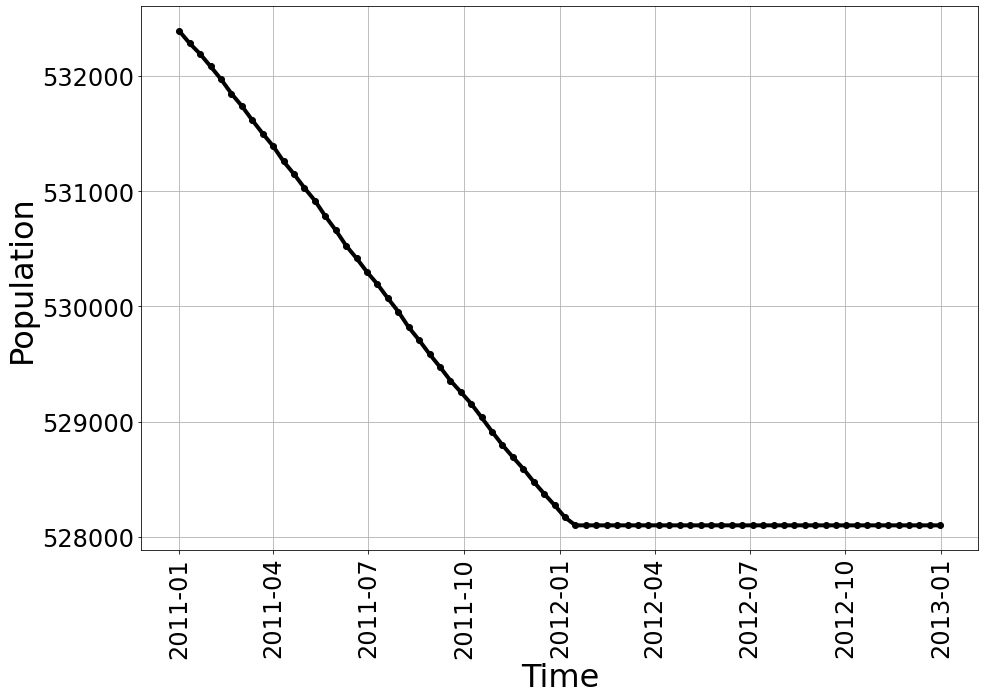

In [29]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_axis, 
         c='k', lw=4, marker="o")
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

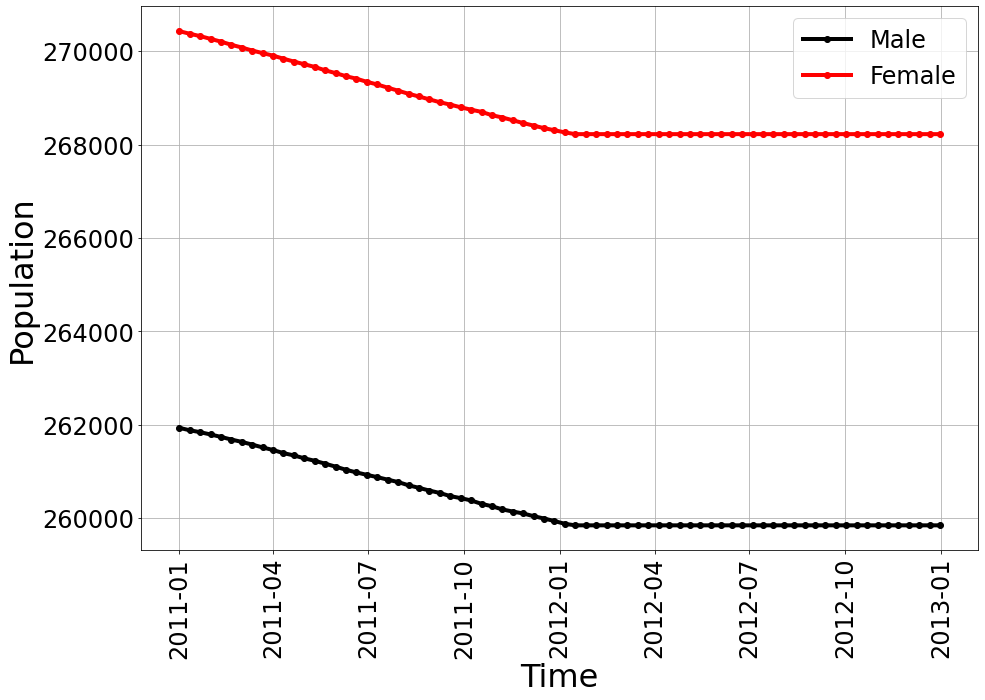

In [30]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_M_axis, 
         c='k', lw=4, marker="o", 
         label="Male"
        )
plt.plot(time_axis, population_F_axis, 
         c='r', lw=4, marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

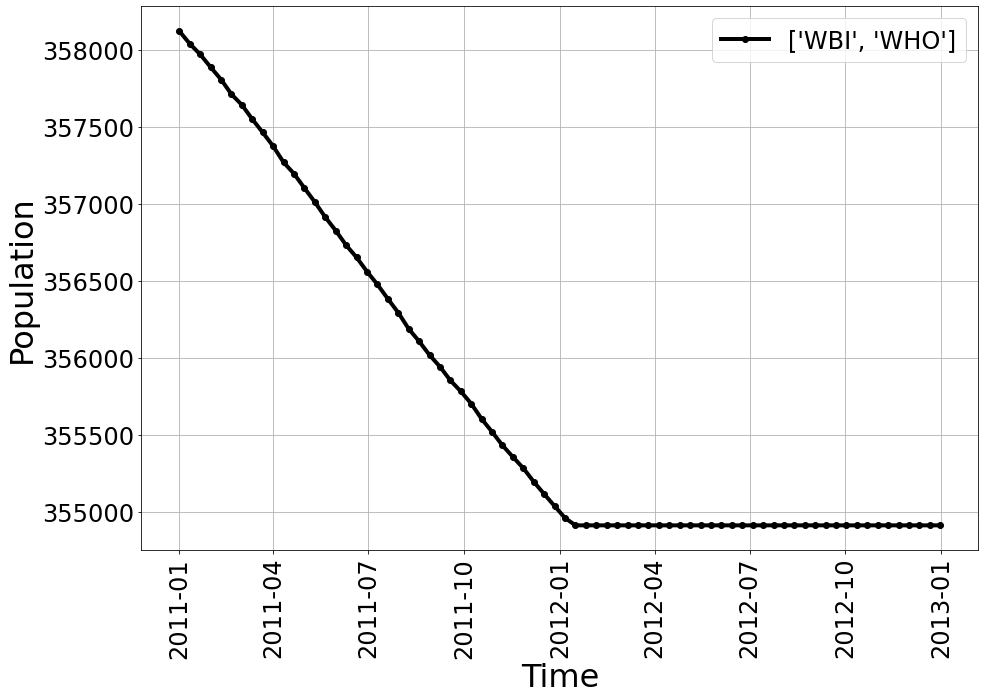

In [31]:
# Population (ethnicity)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_ETH_axis, 
         c='k', lw=4, marker="o", 
         label=sel_ethnicity
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

## Histograms

In [32]:
# only dead population
pop_dead = pop[pop["alive"] != "alive"]

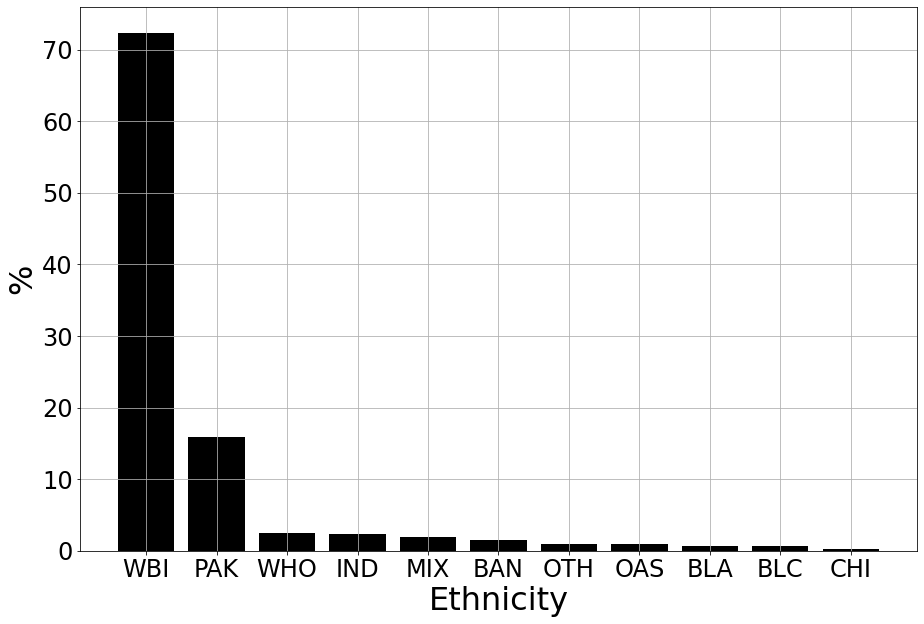

In [33]:
series2plot = pop_dead['ethnicity'].value_counts() / len(pop_dead["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

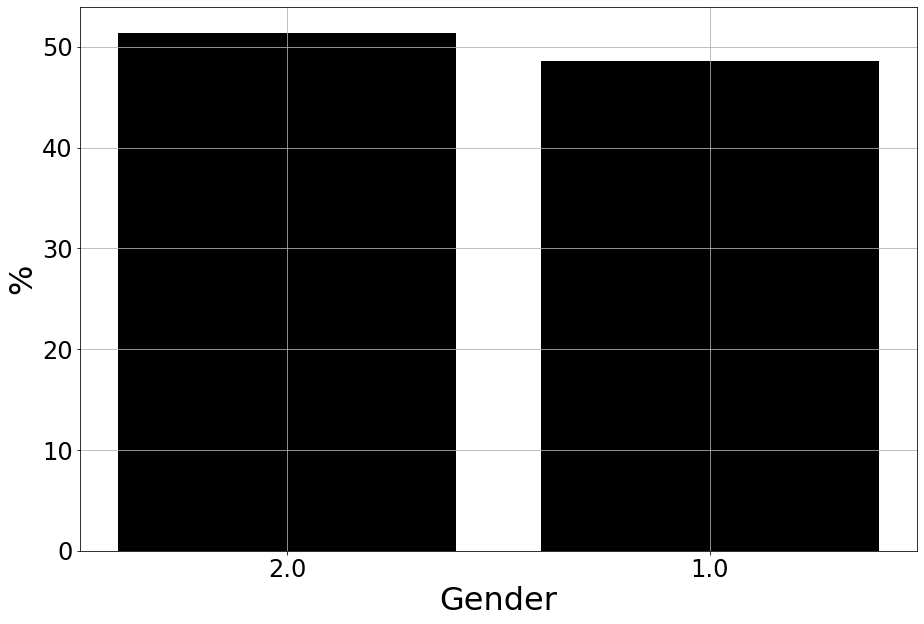

In [34]:
series2plot = pop_dead['sex'].value_counts() / len(pop_dead["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

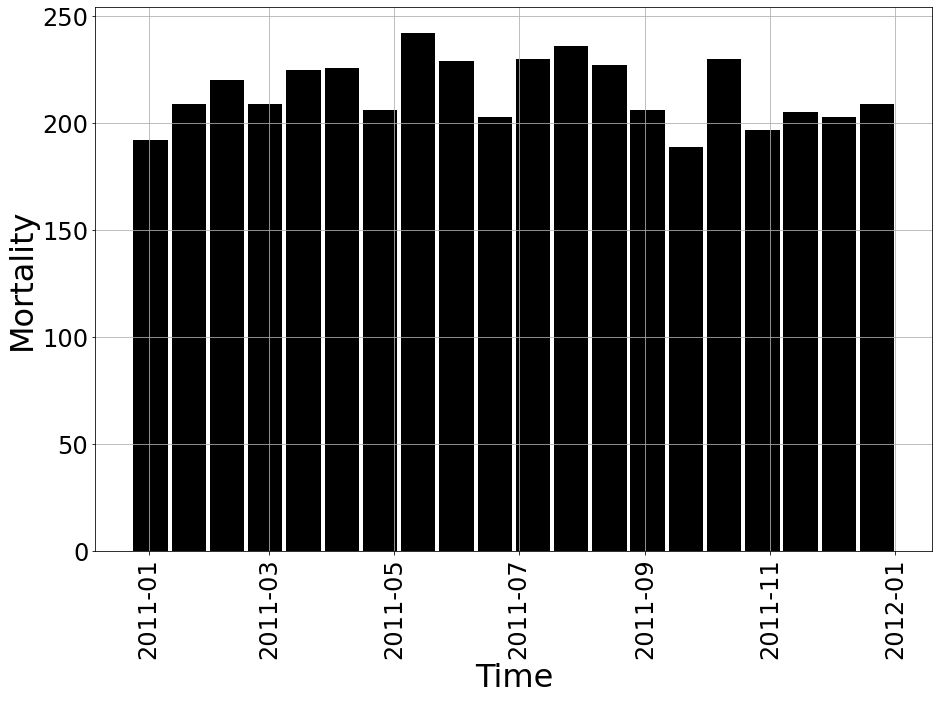

In [35]:
plt.figure(figsize=(15, 10))

pop_dead["exit_time"].hist(bins=20, 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

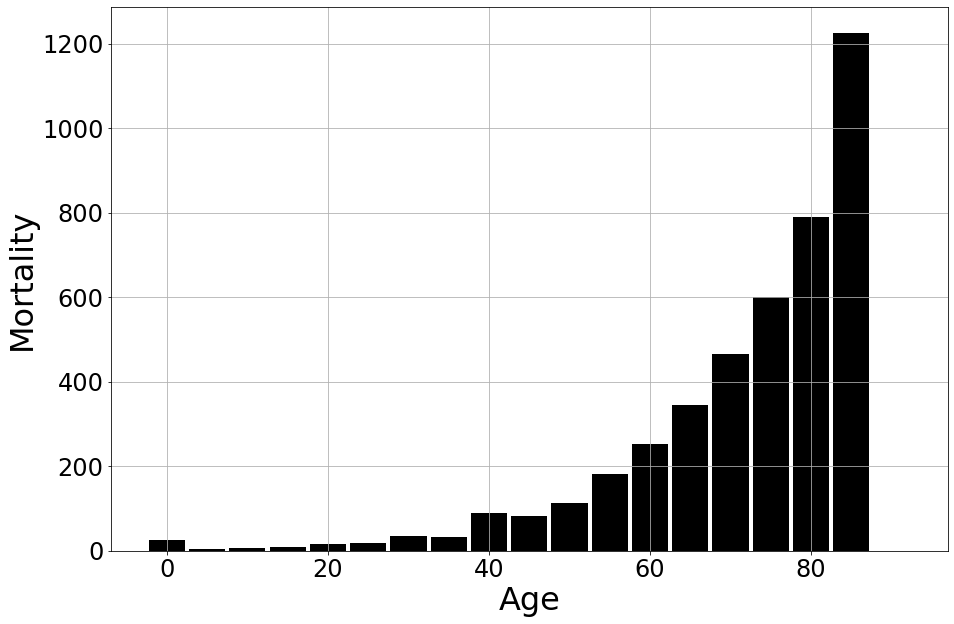

In [36]:
plt.figure(figsize=(15, 10))

pop_dead["age"].hist(bins=range(0, 100, 5), 
                     rwidth=0.9, 
                     color='k',
                     align='left'
                    )
plt.xlabel("Age", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

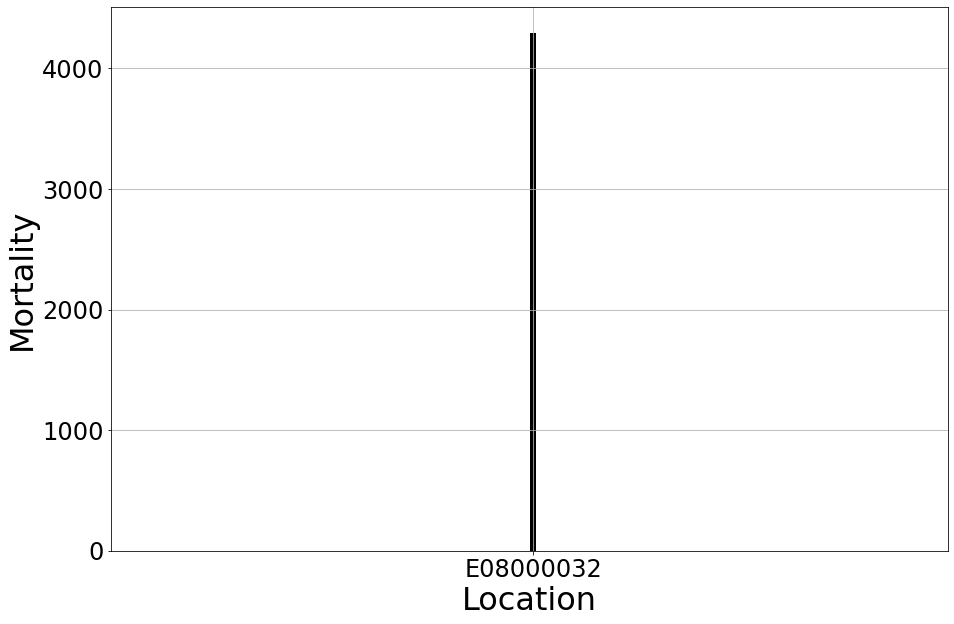

In [37]:
plt.figure(figsize=(15, 10))

pop_dead["location"].hist(bins=100, 
                          rwidth=0.9, 
                          color='k',
                          align="left"
                         )
plt.xlabel("Location", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

# Fetility

In [38]:
pop_births = pop[pop['parent_id']!= -1]

## Ethnicity of new births

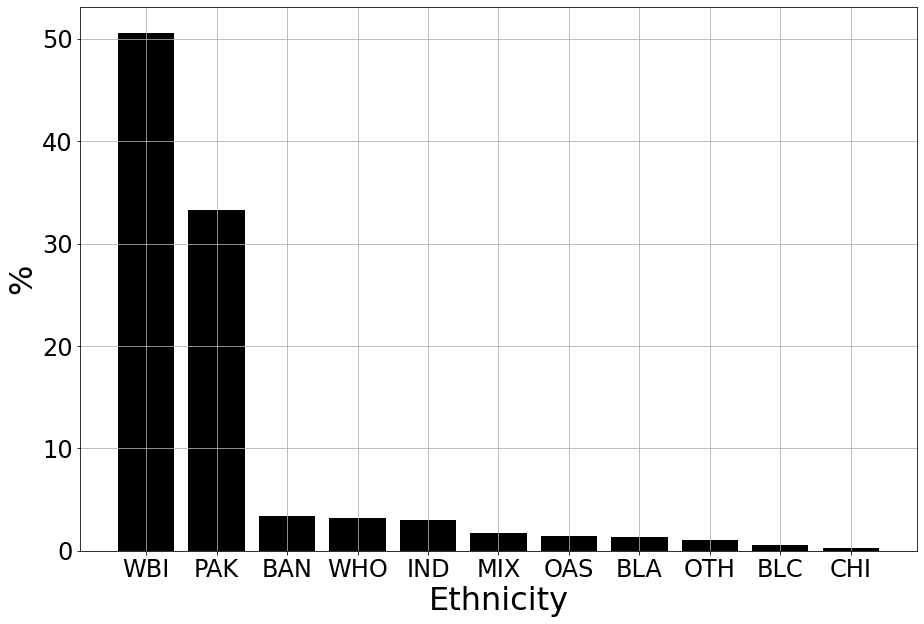

In [39]:
series2plot_births = pop_births['ethnicity'].value_counts() / len(pop_births["ethnicity"]) * 100.
indx = range(len(series2plot_births))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot_births, color='k')

plt.xticks(indx, series2plot_births.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

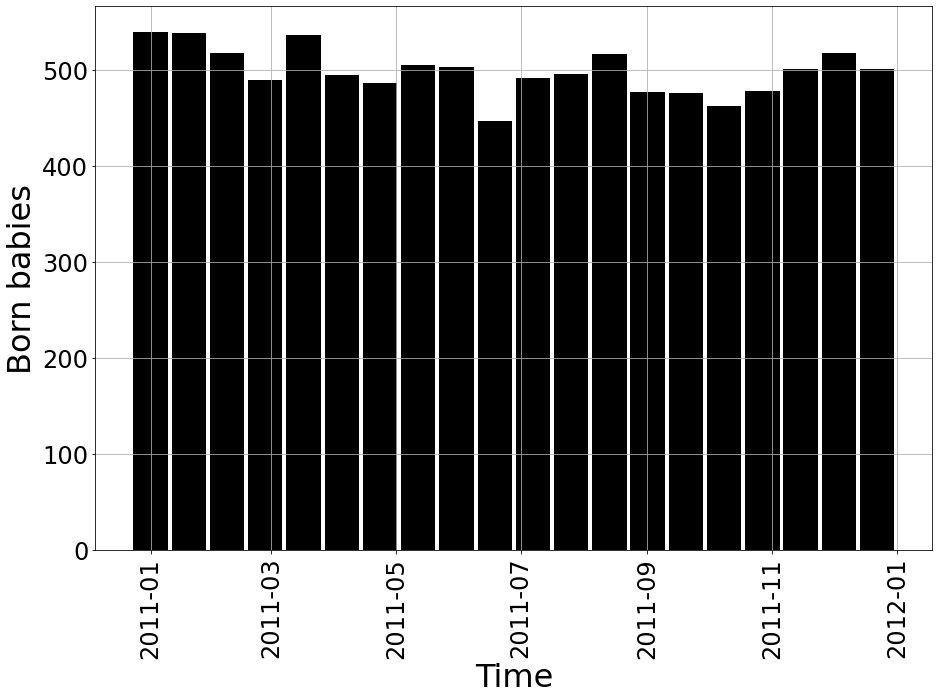

In [41]:
plt.figure(figsize=(15, 10))

pop_births["entrance_time"].hist(bins=20, 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Born babies", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

## Age of mothers

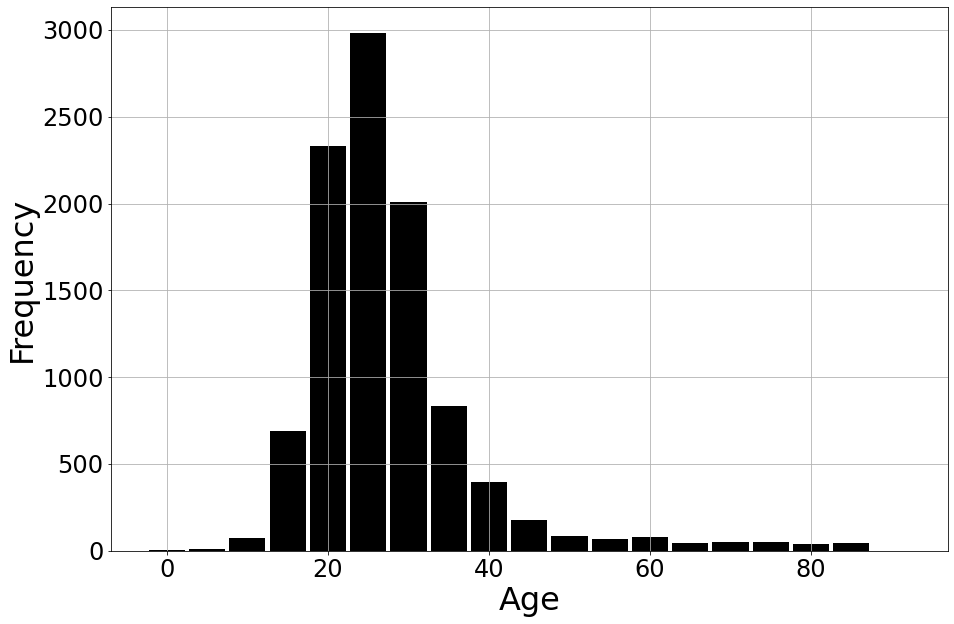

In [49]:
plt.figure(figsize=(15, 10))

pop.iloc[pop_births["parent_id"]]["age"].hist(bins=range(0, 100, 5), 
                     rwidth=0.9, 
                     color='k',
                     align='left'
                    )
plt.xlabel("Age", size=32)
plt.ylabel("Frequency", size=32)
plt.xticks(size=24)
plt.yticks(size=24)

#plt.legend(fontsize=24)
plt.show()